# Gambler's problem

In [2]:
import numba
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit

In [3]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Value iteration

The value iteration algorithm is given by following the following update rule:

$$
\begin{aligned}
    v_{k+1}(s) :&= \max_a \mathbb{E}[R_{t+1} + \gamma v_k(S_{t+1}) \vert S_t = s, A_t=a]\\
    &= \max_a\sum_{s', r}p(s', r \vert s, a)\left[r + \gamma v_k(s')\right]
\end{aligned}
$$

* For arbitrary $v_0$, the sequence $v_1, v_2, \ldots$ can be shown to converge to $v_*$ under the same conditions that guarantee the existence of $v_*$ using the policy iteration algorithm.

### Policy improvement
Compare the **value iteration** algorithm to the **policy iteration** algorithm which first tries to find the value function given a policy $\pi$. That is, we try to find $\forall s\in\mathcal{S}.v_\pi(s)$ such that

$$
    v_\pi(s) = \sum_{a} \pi(a\vert s) \sum_{s', r} p(s', r \vert s, a)\left[r + \gamma v_\pi(s')\right] \ \forall s \in \mathcal{S}.
$$

After finding an optimal set of value functions $v_{\pi}(s)$, we *improve* the policy greedily instantiating a new policy $\pi'$ such that

$$
    \pi'(s) = \text{argmax}_a \sum_{s', r} p(s', r \vert s, a)[r + \gamma v_\pi(s)] \ \forall s \in \mathcal{S}.
$$

# The gambler's problem

* A gambler can make bets on a sequence of coins tosses. The probability of heads is given by $p_h$
* Before each toss the gambler decides how much to risk. If the coin lands heads, the gambler wins as many dollars as he has risked on that flip; if it is tail, he loses his stake.
* The game ends when the gambler wins by reaching his goal of $100, or loses by running out of money.

## The setup

* The set of states is the gambler's capital: $\mathcal S = \{1, 2, \ldots, 99\}$
* The set of actions, given a state, are the stakes: $\mathcal{A}_{s} = \{0, 1, \ldots, \min(s, 100 - s)\}$

$$
\begin{aligned}
    \mathbb{P}(S_t=s', R_t=r \vert S_{t-1}=s, A_t=a) &= \mathbb{P}(S_t=s'\vert S_{t-1}=s, A_t=a)\mathbb{P}(R_t=r \vert S_{t}=s')\\
    &= \mathbb{P}(S_t=s'\vert S_{t-1}=s, A_t=a) \mathbb{1}(s' = 100)
\end{aligned}
$$

For every state $s \in \{0,1, 2, \ldots, 98\}$,

$$
\begin{aligned}
    p(s + a, 0, \vert s, a) &= p_h\\
    p(s - a, 0, \vert s, a) &=1  - p_h\\
\end{aligned}
$$

In the special case where $s=99$,

\begin{aligned}
    p(s + a, 1, \vert s, a) &= p_h\\
    p(s - a, 0, \vert s, a) &=1  - p_h\\
\end{aligned}

In [4]:
max_capital = 100
p_heads = 0.4
p = np.array([p_heads, 1 - p_heads])

### Set of actions
Action upper bound as a function of the capital.
Note that the triangular form is due to the constraint of being able to stake at most 100.

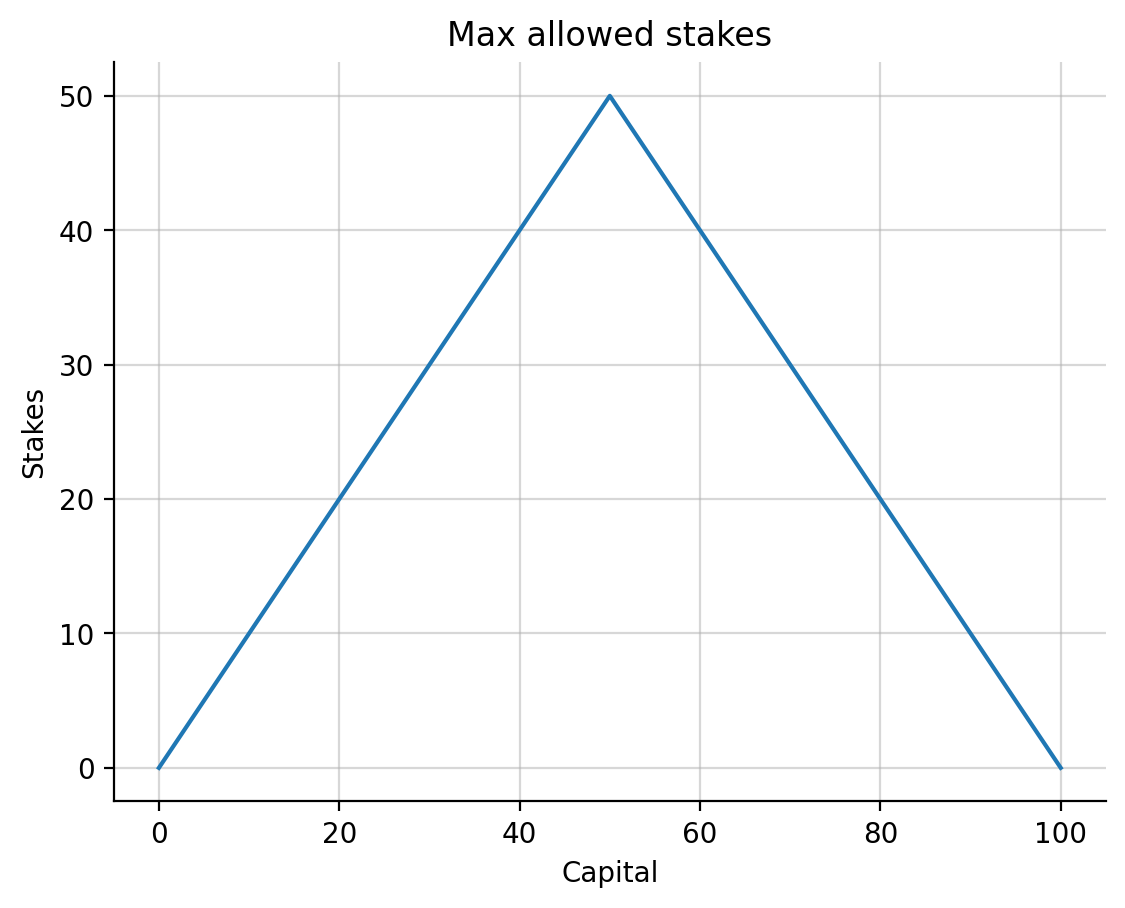

In [260]:
capital_range = np.arange(0, 101)
actions = np.minimum(capital, 100 - capital)
plt.plot(capital, actions)

plt.title("Max allowed stakes")
plt.xlabel("Capital")
plt.ylabel("Stakes")
plt.grid(alpha=0.5)

In [334]:
from numba import float64, int64

In [335]:
@njit(float32(int64, int64, int64, int64))
def pr_mdp(new_capital, reward, capital, stake):
    """
    Markov decision process
    P(s', r | s, a)
    """
    # Either we earn as much as we risked or lose our stakes
    proba = p_heads * (new_capital == capital + stake) + (1 - p_heads) * (new_capital == capital - stake)
    
    # Either the reward is zero, and the new capital is in the range [0, 100),
    # or the reward is one, but we reach the terminal state.
    valid_reward = (
        (reward == 0) * (new_capital < max_capital) * (new_capital >= 0) +
        (reward == 1) * (new_capital == max_capital)
    )
    
    # 
    valid_stakes = stake <= np.minimum(capital, max_capital - capital)
    
    proba = proba * valid_reward * valid_stakes
    proba = (
        proba * (capital < max_capital) * (capital > 0) * (stake > 0)
        ## Absorbing states
        + (capital == max_capital) * (new_capital == max_capital) * (reward == 0)
        + (capital == 0) * (new_capital == 0) * (reward == 0)
         # Probabilty of staying in the same state (not needed?)
         + 0 * (stake == 0) * (reward == 0) * (capital == new_capital) * (capital < max_capital) * (capital > 0)

    )
    
    return proba

@njit(float32(int64, int64, float64[:], float64))
def action_value_function(capital, stakes, value_function, discount):
    new_capital_choices = [capital + stakes, capital - stakes]
    new_capital_choices = np.arange(capital - stakes, capital + stakes + 1)
    
    vpi = 0.0
    reward_range = [0.0, 1.0]
    for new_capital in new_capital_choices:
        for reward in reward_range:
            vfprime = value_function[new_capital]
            vpi += pr_mdp(new_capital, reward, capital, stakes) * (reward + discount * vfprime)
    return vpi

In [350]:
discount = 1.0
capital_range = np.arange(max_capital + 1)
# capital_range = np.arange(1, max_capital)
stakes_range = np.arange(max_capital // 2 + 1) # stakes begin at 1?

value_function = np.zeros_like(capital_range).astype(float)
value_function[-1] = 1

In [351]:
action_value_function(50, 50, value_function, 1.0)

0.800000011920929

In [371]:
@njit
def single_value_function(capital, value_function, discount):
    max_allowed_stakes = np.minimum(capital, max_capital - capital)
    stakes = np.arange(max_allowed_stakes + 1)
    
    v_max, stake_max = -1, -1
    
    for stake in stakes:
        v_action = action_value_function(capital, stake, value_function, discount)
        if v_action > v_max:
            v_max = v_action
            stake_max = stake
    
    return v_action, stake_max


@njit(parallel=True)
def compute_value_function(value_function, discount):
    nstates = len(capital_range)
    
    new_value_function = np.zeros(nstates)
    policy = np.zeros(nstates)
    
    for i in numba.prange(nstates):
        capital = capital_range[i]
        vpi, stake_max = single_value_function(capital, value_function, discount)
        new_value_function[i] = vpi
        policy[i] = stake_max
    
    return new_value_function, policy

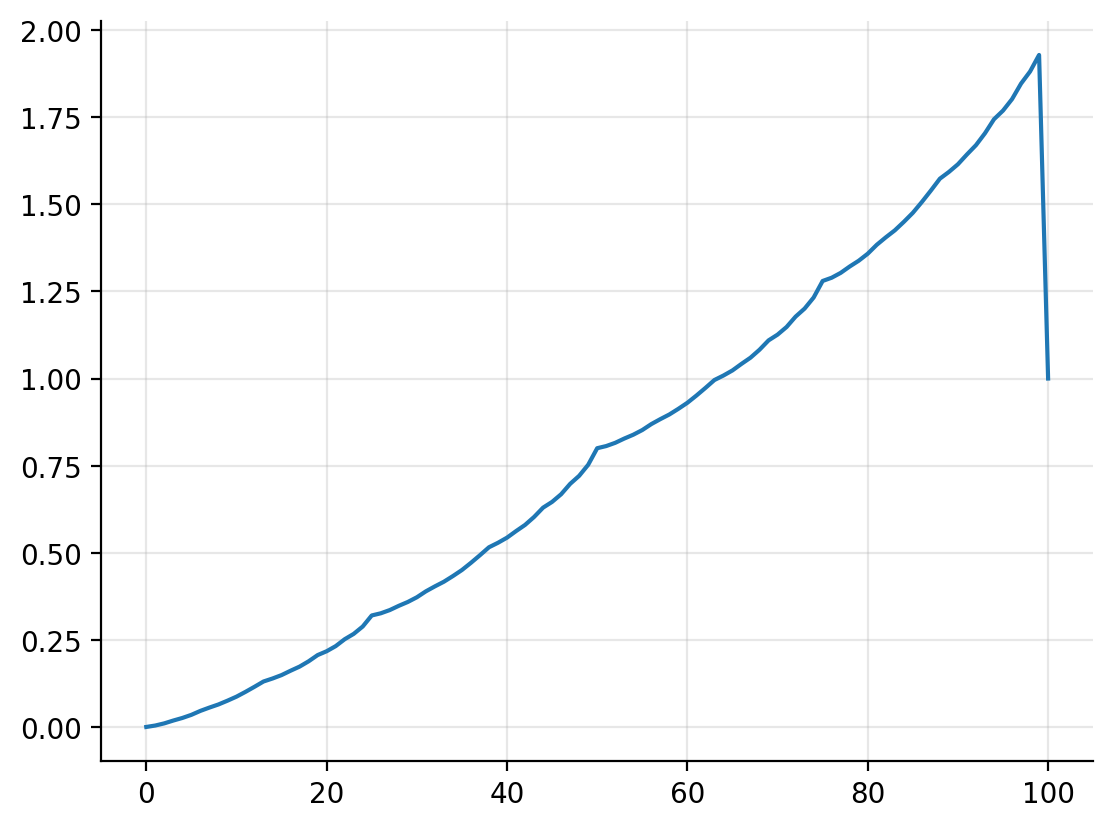

In [377]:
value_function, policy = compute_value_function(value_function, discount)

plt.plot(capital_range, value_function)
plt.grid(alpha=0.3)

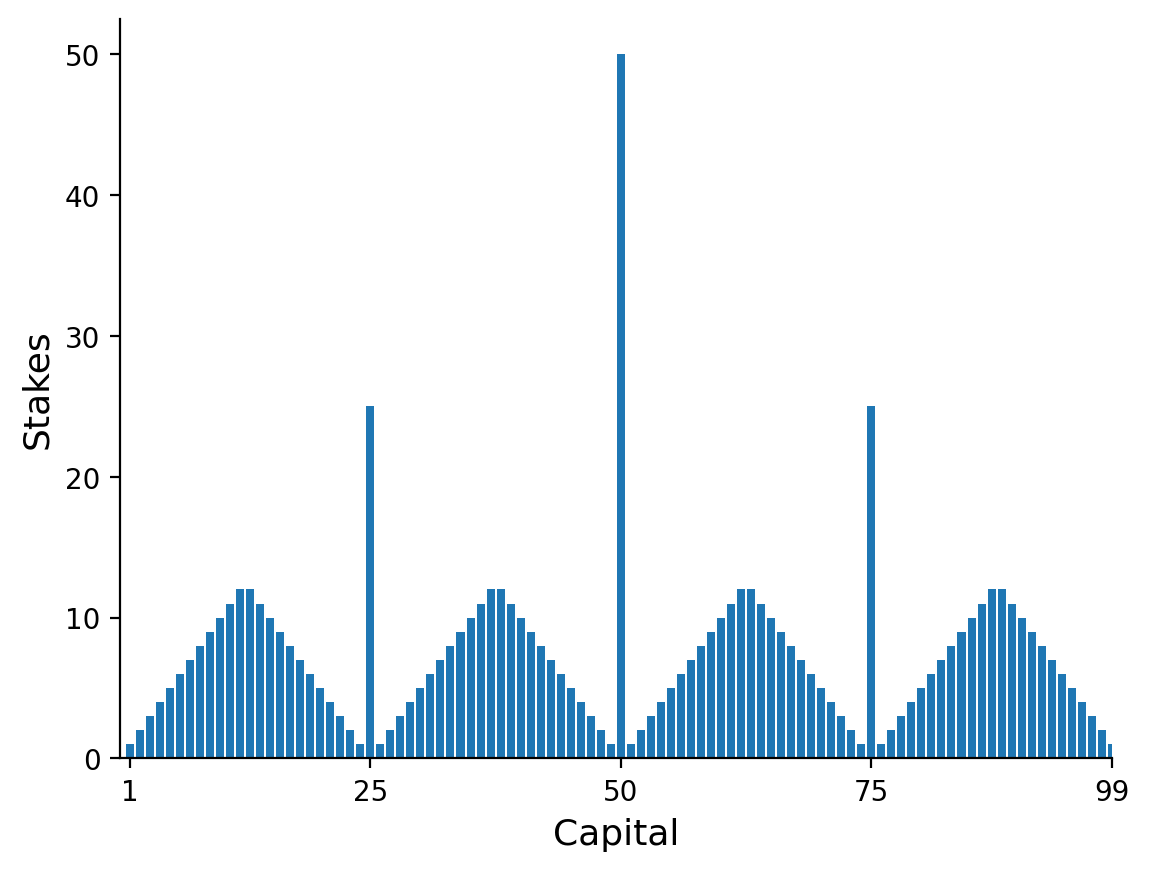

In [378]:
plt.bar(np.arange(max_capital +1 ), policy)
plt.xlim(0, max_capital-1)
plt.xlabel("Capital", fontsize=13)
plt.ylabel("Stakes", fontsize=13)
plt.xticks([1, 25, 50, 75, 99]);

$$
\begin{aligned}
    v_{k+1}(s) :&= \max_a \mathbb{E}[R_{t+1} + \gamma v_k(S_{t+1}) \vert S_t = s, A_t=a]\\
    &= \max_a\sum_{s', r}p(s', r \vert s, a)\left[r + \gamma v_k(s')\right]
\end{aligned}
$$


## Jax

In [ ]:
key = jax.random.PRNGKey(314)


p_heads = 0.4
p = jnp.array([p_heads, 1 - p_heads])
elements = jnp.array([0, 1])

In [ ]:
# We want to make sure we stay within the set of states 1,...,100
# to-do: play with the assymetry of the stakes. What happens if he can go "all in"?
#        note that in this case, we must change the states. Furthermore, the problem might
#        not be periodic. (We will need a discount factor)
capital = jnp.arange(1, 100)
plt.plot(capital, jnp.minimum(capital, 100 - capital))
plt.title("Max allowed stakes")
plt.xlabel("Capital")
plt.ylabel("Stakes")
plt.grid(alpha=0.5)

In [5]:
max_capital = 100

def p_state(capital, new_capital, stake, reward):
    proba = p_heads * (new_capital == capital + stake) + (1 - p_heads) * (new_capital == capital - stake)
    
    # Either the reward is zero, and the new capital is in the range [0, 100),
    # or the reward is one, but we reach the terminal state.
    valid_reward = (reward == 0) * (new_capital < max_capital) * (new_capital >= 0) + (reward == 1) * (new_capital == max_capital)
    valid_stakes = stake <= jnp.minimum(capital, max_capital - capital)
    
    proba = proba * valid_stakes * valid_reward
    
    return (proba * (capital < max_capital) * (capital > 0) * (stake > 0)
         # absorbing states
         + (capital == max_capital) * (new_capital == max_capital) * (reward == 0)
         + (capital == 0) * (new_capital == 0) * (reward == 0)
         # Probabilty of staying in the same state (not needed?)
         + 0 * (stake == 0) * (reward == 0) * (capital == new_capital) * (capital < max_capital) * (capital > 0))

p_state_grid = jax.vmap(p_state,      (   0, None, None, None), out_axes=0)
p_state_grid = jax.vmap(p_state_grid, (None,    0, None, None), out_axes=1)
p_state_grid = jax.vmap(p_state_grid, (None, None,    0, None), out_axes=2)
p_state_grid = jax.vmap(p_state_grid, (None, None, None,    0), out_axes=3)

capital_range = jnp.arange(max_capital + 1)
stakes_range = jnp.arange(max_capital // 2 + 1) # stakes begin at 1?
reward_range = jnp.arange(2)

p_grid = p_state_grid(capital_range, capital_range, stakes_range, reward_range)

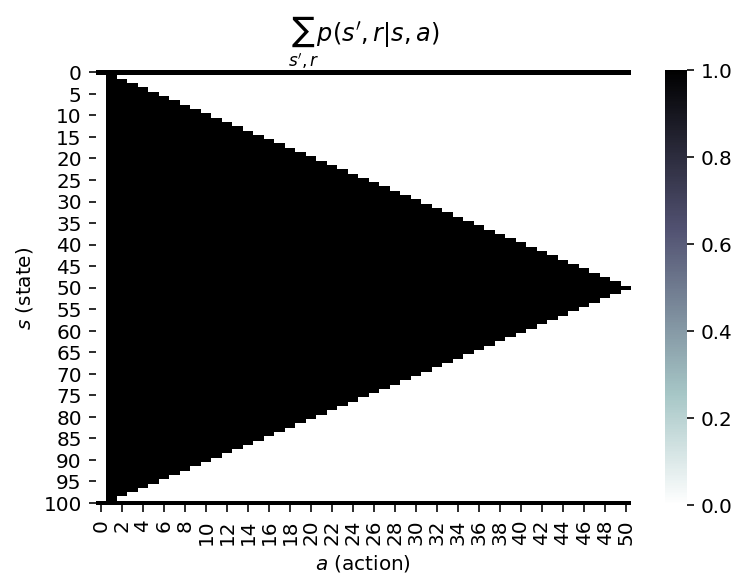

In [6]:
# asserting sum over probabilities
# Σ_{new_capital, reward} p(new_capital, reward | capital, stake)
p_assert = p_grid.sum(axis=1).sum(axis=-1)
sns.heatmap(p_assert, cmap="bone_r")
plt.title(r"$\sum_{s', r} p(s', r \vert s, a)$")
plt.ylabel("$s$ (state)")
plt.xlabel("$a$ (action)");

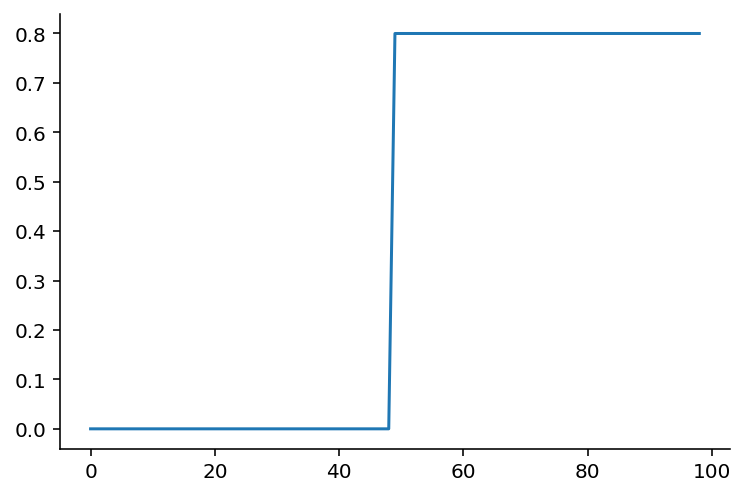

In [30]:
value_function = jnp.zeros_like(capital_range)
value_function = value_function.at[-1].set(1)

reward_value_next = reward_range[None, :] + value_function[:, None]
value_function = jnp.einsum("sjar,jr->as", p_grid, reward_value_next).max(axis=0)

plt.plot(value_function[1:-1])

In [31]:
n_elements = max_capital + 1
value_function = jnp.zeros(n_elements)

sweep_hist = []

converged = False
it = 0
while not converged:
    reward_value_next = reward_range[None, :] + value_function[:, None]
    value_function_update = jnp.einsum("sjar,jr->as", p_grid, reward_value_next).max(axis=0)
    
    err = jnp.max(jnp.abs(value_function - value_function_update)).max()
    converged = (err < 1e-20)
    value_function = value_function_update
    
    
    sweep_hist.append(value_function)
    it += 1

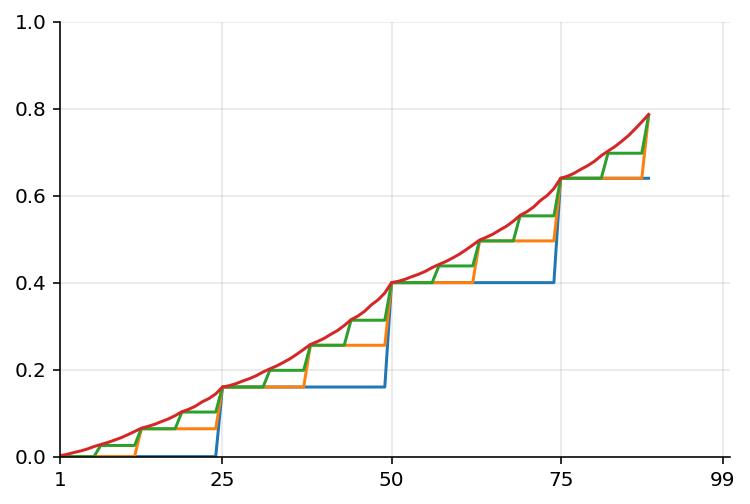

In [48]:
it_sweeps = [1, 2, 3, -1]
sweep_hist = jnp.stack(sweep_hist, axis=0)
plt.plot(sweep_hist[jnp.array(it_sweeps)].T)
plt.ylim(0,1)
plt.xlim(1, max_capital)
plt.xticks([1, 25, 50, 75, 99]);
plt.grid(alpha=0.3);

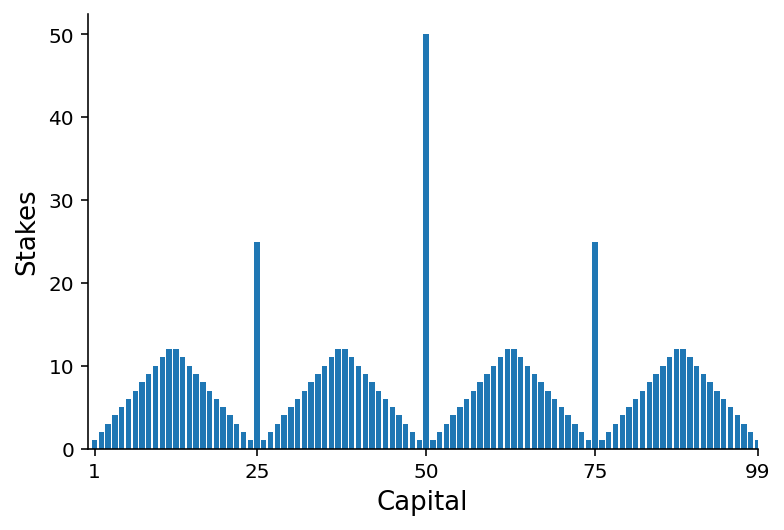

In [52]:
reward_value_next = reward_range[None, :] + value_function[:, None]
policy = jnp.einsum("sjar,jr->as", p_grid, reward_value_next).round(6).argmax(axis=0)[1:-1]
plt.bar(jnp.arange(1,max_capital), policy)
plt.xlim(0, max_capital-1)
plt.xlabel("Capital", fontsize=13)
plt.ylabel("Stakes", fontsize=13)
plt.xticks([1, 25, 50, 75, 99]);

In [14]:
π_prob = jnp.einsum("sjar,jr->as", p_grid, reward_value_next)
π_prob = jnp.nan_to_num(π_prob / π_prob.sum(axis=0, keepdims=True))